In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import sympy as sp
import pandas as pd
import HOHWM

Linear Fredholm integral equations (HOHWM s = 1)




In [12]:
def Fredholm_1st_iterative_method(
    N, f, K, method="GMRES", tol=1e-8, max_iter=200, verbose=False
):
    # define the system of equations for the iterative method
    def sys_eqs(coef_haar):
        N = len(coef_haar)
        x = HOHWM.collocation(N)
        t = HOHWM.collocation(N)
        eqs = np.zeros(N)

        S_1 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        S_1 = 1 / N * S_1

        S_2 = 0
        for k in range(N):
            S_2 += K(0, t[k])
        S_2 = 1 / N * S_2

        # Haar part
        M_A = np.zeros((N, N))
        for j in range(N):
            for k in range(N):
                M_A[:, j] += K(x, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        M_A = HOHWM.haar_int_1_mat(x, N) - 1 / N * M_A

        V_B = np.zeros(N)
        for k in range(N):
            V_B += K(x, t[k])
        V_B = 1 - 1 / N * V_B

        eqs = np.dot(M_A, coef_haar) - (
            f(x) - 1 / (1 - S_2) * (f(0) + np.dot(coef_haar, S_1)) * V_B
        )

        return eqs

    def Jac(coef_haar):
        N = len(coef_haar)
        x = HOHWM.collocation(N)
        t = HOHWM.collocation(N)
        jac = np.zeros((N, N))

        S_1 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        S_1 = 1 / N * S_1

        S_2 = 0
        for k in range(N):
            S_2 += K(0, t[k])
        S_2 = 1 / N * S_2

        M_A = np.zeros((N, N))
        for j in range(N):
            for k in range(N):
                M_A[:, j] += K(x, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        M_A = HOHWM.haar_int_1_mat(x, N) - 1 / N * M_A

        V_B = np.zeros(N)
        for k in range(N):
            V_B += K(x, t[k])
        V_B = 1 - 1 / N * V_B

        jac = M_A + 1 / (1 - S_2) * np.outer(V_B, S_1)

        return jac

    def newton(coef_haar, tol=tol, max_iter=max_iter, method=method, verbose=verbose):
        coef_haar = coef_haar.copy()

        # iter number
        iter = 0

        for i in range(max_iter):
            F = sys_eqs(coef_haar)
            J = Jac(coef_haar)

            if method == "LU":
                delta = np.linalg.solve(J, -F)  # LU
            elif method == "CG":
                delta = sla.cg(J, -F)[0]
            elif method == "GMRES":
                delta = sla.gmres(J, -F)[0]
            elif method == "MINRES":
                delta = sla.minres(J, -F)[0]
            else:
                raise NotImplementedError("Only support LU, CG, GMRES, MINRES")

            coef_haar += delta
            iter += 1

            if np.linalg.norm(delta) < tol:
                break
        if verbose:
            print("iter: ", iter)
            # print("delta: ", delta)
            # print("coefs: ", coefs)

        if iter == max_iter:
            # print("Warning: Newton's method does not converge!")
            iter = -1  # return -1 if the method does not converge

        return coef_haar, iter

    coef_haar = np.zeros(N)  # initial guess
    coef_haar, iter = newton(
        coef_haar, tol=tol, max_iter=max_iter, method=method, verbose=verbose
    )

    # compute constant C1
    x = HOHWM.collocation(N)
    t = HOHWM.collocation(N)

    S_1 = np.zeros(N)
    for j in range(N):
        for k in range(N):
            S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
    S_1 = 1 / N * S_1

    S_2 = 0
    for k in range(N):
        S_2 += K(0, t[k])
    S_2 = 1 / N * S_2

    C_1 = 1 / (1 - S_2) * (f(0) + np.dot(coef_haar, S_1))

    # define approximated function
    def u_haar_approx_func(x):
        # superposition of the Haar wavelet functions
        approx_func_val = C_1
        for k in range(N):
            approx_func_val += coef_haar[k] * HOHWM.haar_int_1(x, k + 1)
        return approx_func_val

    return u_haar_approx_func, iter

In [23]:
# 2nd
def Fredholm_2nd_iterative_method(
    N, f, K, method="GMRES", tol=1e-8, max_iter=200, verbose=False
):
    # define the system of equations for the iterative method
    def sys_eqs(coef_haar):
        N = len(coef_haar)
        x = HOHWM.collocation(N)
        t = HOHWM.collocation(N)
        eqs = np.zeros(N)

        S_1 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        S_1 = 1 / N * S_1

        S_2 = 0
        for k in range(N):
            S_2 += K(0, t[k])
        S_2 = 1 / N * S_2

        S_3 = 0
        for k in range(N):
            S_3 += K(1, t[k])
        S_3 = 1 / N * S_3

        S_4 = 0
        for k in range(N):
            S_4 += K(0, t[k]) * t[k]
        S_4 = 1 / N * S_4

        S_5 = 0
        for k in range(N):
            S_5 += K(1, t[k]) * t[k]
        S_5 = 1 / N * S_5

        S_6 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_6[j] += K(0, t[k]) * HOHWM.haar_int_2(t[k], j + 1)
        S_6 = 1 / N * S_6

        S_7 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_7[j] += K(1, t[k]) * HOHWM.haar_int_2(t[k], j + 1)
        S_7 = 1 / N * S_7

        S_8 = 1 - S_2 + S_4 * (1 - S_3) - S_5 * (1 - S_2)

        A = f(0) * (1 - S_5) + f(1) * S_4

        D = -f(0) * (1 - S_3) + f(1) * (1 - S_2)

        V_B = np.zeros(N)
        for i in range(N):
            V_B[i] = HOHWM.haar_int_2(1, i + 1)
        V_B -= S_7

        V_E = (1 - S_5) * S_6 - S_4 * V_B

        V_F = (1 - S_3) * S_6 + (1 - S_2) * V_B

        M_A = np.zeros((N, N))
        for i in range(N):
            for k in range(N):
                M_A[:, i] += K(x, t[k]) * HOHWM.haar_int_2(t[k], i + 1)
        M_A = HOHWM.haar_int_2_mat(x, N) - 1 / N * M_A

        V_P = np.zeros(N)
        for k in range(N):
            V_P += K(x, t[k])
        V_P = 1 - 1 / N * V_P

        V_Q = np.zeros(N)
        for k in range(N):
            V_Q += K(x, t[k]) * t[k]
        V_Q = x - 1 / N * V_Q

        C1 = 1 / S_8 * (A + np.dot(coef_haar, V_E))
        C2 = 1 / S_8 * (D - np.dot(coef_haar, V_F))

        eqs = np.dot(M_A, coef_haar) - f(x) + C1 * V_P + C2 * V_Q

        return eqs

    def Jac(coef_haar):
        N = len(coef_haar)
        x = HOHWM.collocation(N)
        t = HOHWM.collocation(N)
        jac = np.zeros((N, N))

        S_1 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
        S_1 = 1 / N * S_1

        S_2 = 0
        for k in range(N):
            S_2 += K(0, t[k])
        S_2 = 1 / N * S_2

        S_3 = 0
        for k in range(N):
            S_3 += K(1, t[k])
        S_3 = 1 / N * S_3

        S_4 = 0
        for k in range(N):
            S_4 += K(0, t[k]) * t[k]
        S_4 = 1 / N * S_4

        S_5 = 0
        for k in range(N):
            S_5 += K(1, t[k]) * t[k]
        S_5 = 1 / N * S_5

        S_6 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_6[j] += K(0, t[k]) * HOHWM.haar_int_2(t[k], j + 1)
        S_6 = 1 / N * S_6

        S_7 = np.zeros(N)
        for j in range(N):
            for k in range(N):
                S_7[j] += K(1, t[k]) * HOHWM.haar_int_2(t[k], j + 1)
        S_7 = 1 / N * S_7

        S_8 = 1 - S_2 + S_4 * (1 - S_3) - S_5 * (1 - S_2)

        A = f(0) * (1 - S_5) + f(1) * S_4

        D = -f(0) * (1 - S_3) + f(1) * (1 - S_2)

        V_B = np.zeros(N)
        for i in range(N):
            V_B[i] = HOHWM.haar_int_2(1, i + 1)
        V_B -= S_7

        V_E = (1 - S_5) * S_6 - S_4 * V_B

        V_F = (1 - S_3) * S_6 + (1 - S_2) * V_B

        M_A = np.zeros((N, N))
        for i in range(N):
            for k in range(N):
                M_A[:, i] += K(x, t[k]) * HOHWM.haar_int_2(t[k], i + 1)
        M_A = HOHWM.haar_int_2_mat(x, N) - 1 / N * M_A

        V_P = np.zeros(N)
        for k in range(N):
            V_P += K(x, t[k])
        V_P = 1 - 1 / N * V_P

        V_Q = np.zeros(N)
        for k in range(N):
            V_Q += K(x, t[k]) * t[k]
        V_Q = x - 1 / N * V_Q

        jac = M_A + np.outer(V_P, V_E) / S_8 - np.outer(V_Q, V_F) / S_8

        return jac

    def newton(coef_haar, tol=tol, max_iter=max_iter, method=method, verbose=verbose):
        coef_haar = coef_haar.copy()

        # iter number
        iter = 0

        for i in range(max_iter):
            F = sys_eqs(coef_haar)
            J = Jac(coef_haar)

            if method == "LU":
                delta = np.linalg.solve(J, -F)  # LU
            elif method == "CG":
                delta = sla.cg(J, -F)[0]
            elif method == "GMRES":
                delta = sla.gmres(J, -F)[0]
            elif method == "MINRES":
                delta = sla.minres(J, -F)[0]
            else:
                raise NotImplementedError("Only support LU, CG, GMRES, MINRES")

            coef_haar += delta
            iter += 1

            if np.linalg.norm(delta) < tol:
                break
        if verbose:
            print("iter: ", iter)
            # print("delta: ", delta)
            # print("coefs: ", coefs)

        if iter == max_iter:
            # print("Warning: Newton's method does not converge!")
            iter = -1  # return -1 if the method does not converge

        return coef_haar, iter

    coef_haar = np.zeros(N)  # initial guess
    coef_haar, iter = newton(
        coef_haar, tol=tol, max_iter=max_iter, method=method, verbose=verbose
    )
    
    # compute constant C1 and C2
    x = HOHWM.collocation(N)
    t = HOHWM.collocation(N)

    S_1 = np.zeros(N)
    for j in range(N):
        for k in range(N):
            S_1[j] += K(0, t[k]) * HOHWM.haar_int_1(t[k], j + 1)
    S_1 = 1 / N * S_1

    S_2 = 0
    for k in range(N):
        S_2 += K(0, t[k])
    S_2 = 1 / N * S_2

    S_3 = 0
    for k in range(N):
        S_3 += K(1, t[k])
    S_3 = 1 / N * S_3

    S_4 = 0
    for k in range(N):
        S_4 += K(0, t[k]) * t[k]
    S_4 = 1 / N * S_4

    S_5 = 0
    for k in range(N):
        S_5 += K(1, t[k]) * t[k]
    S_5 = 1 / N * S_5

    S_6 = np.zeros(N)
    for j in range(N):
        for k in range(N):
            S_6[j] += K(0, t[k]) * HOHWM.haar_int_2(t[k], j + 1)
    S_6 = 1 / N * S_6

    S_7 = np.zeros(N)
    for j in range(N):
        for k in range(N):
            S_7[j] += K(1, t[k]) * HOHWM.haar_int_2(t[k], j + 1)
    S_7 = 1 / N * S_7

    S_8 = 1 - S_2 + S_4 * (1 - S_3) - S_5 * (1 - S_2)

    A = f(0) * (1 - S_5) + f(1) * S_4

    D = -f(0) * (1 - S_3) + f(1) * (1 - S_2)

    V_B = np.zeros(N)
    for i in range(N):
        V_B[i] = HOHWM.haar_int_2(1, i + 1)
    V_B -= S_7

    V_E = (1 - S_5) * S_6 - S_4 * V_B

    V_F = (1 - S_3) * S_6 + (1 - S_2) * V_B

    M_A = np.zeros((N, N))
    for i in range(N):
        for k in range(N):
            M_A[:, i] += K(x, t[k]) * HOHWM.haar_int_2(t[k], i + 1)
    M_A = HOHWM.haar_int_2_mat(x, N) - 1 / N * M_A

    V_P = np.zeros(N)
    for k in range(N):
        V_P += K(x, t[k])
    V_P = 1 - 1 / N * V_P

    V_Q = np.zeros(N)
    for k in range(N):
        V_Q += K(x, t[k]) * t[k]
    V_Q = x - 1 / N * V_Q

    C1 = 1 / S_8 * (A + np.dot(coef_haar, V_E))
    C2 = 1 / S_8 * (D - np.dot(coef_haar, V_F))

    # define approximated function
    def u_haar_approx_func(x):
        approx_func_val = C1 + C2 * x
        for k in range(N):
            approx_func_val += coef_haar[k] * HOHWM.haar_int_2(x, k + 1)
        return approx_func_val

    return u_haar_approx_func, iter

In [24]:
f = lambda x: np.exp(x) + np.exp(-x)
K = lambda x, t: -np.exp(-(x + t))
u_true = lambda x: np.exp(x)

iter:  2


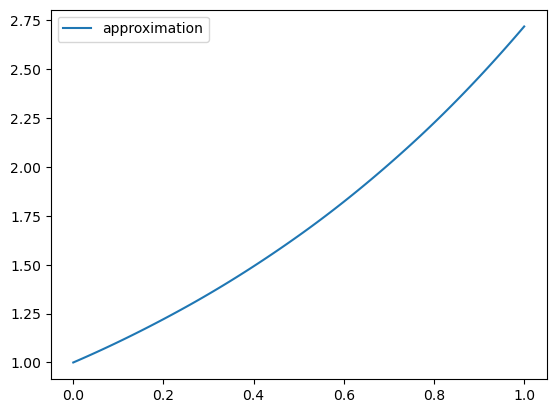

In [25]:
# plot the approximated function
u_approx_func, _ = Fredholm_2nd_iterative_method(4, f, K, method="LU", tol=1e-8, max_iter=200, verbose=True)
x = np.linspace(0, 1, 101)
y = u_approx_func(x)
plt.plot(x, y, label="approximation")
#plt.plot(x, u_true(x), label="true")
plt.legend()
plt.show()

In [31]:
# Compute the error
print_results = True
if print_results is True:
    print("Iterative method for linear Fredholm equation")

    col_size = [2, 4, 8, 16, 32, 64, 128, 256]
    err_local = np.zeros(len(col_size))
    err_global = np.zeros(len(col_size))
    iters = np.zeros(len(col_size))
    
    methods = ["LU", "CG", "GMRES", "MINRES"]

    error_data = np.zeros((len(col_size), len(methods)))
    ERC_data = np.zeros((len(col_size) - 1, len(methods)))
    iter_data = np.zeros((len(col_size), len(methods)))
    
    for s in ["1st", "2nd"]:
        test_x = 0.5  # calculate the error at x = 0.5
        for method in methods:
            for M in col_size:
                if s == "1st":
                    u_approx_func, iter = Fredholm_1st_iterative_method(
                        M, f, K, method=method, tol=1e-8, max_iter=100, verbose=False
                    )
                elif s == "2nd":
                    u_approx_func, iter = Fredholm_2nd_iterative_method(
                        M, f, K, method=method, tol=1e-8, max_iter=100, verbose=False
                    )
                else:
                    raise ValueError("method can only be 1st or 2nd")
                x = np.linspace(0, 1, 101)
                u_true_half = u_true(test_x)
                u_haar_approx_half = u_approx_func(test_x)
                # store the error
                err_local[col_size.index(M)] = abs(u_true_half - u_haar_approx_half)
                # compute the global error with zero-norm
                u_true_vec = u_true(x)
                u_haar_approx_vec = u_approx_func(x)

                iters[col_size.index(M)] = iter
                
            # store the error
            error_data[:, methods.index(method)] = err_local

            # calculate the experimental rate of convergence
            ERC = np.diff(np.log(err_local)) / np.log(2)
            ERC_data[:, methods.index(method)] = ERC

            # store the iteration number
            iter_data[:, methods.index(method)] = iters
            
        # convert to pandas dataframe
        print("s = ", s)

        print("Error at x = {}".format(test_x))
        df_error = pd.DataFrame(error_data, columns=methods)
        df_error.index = col_size
        print(df_error)
        print("\n")

        print("Experimental rate of convergence")
        df_ERC = pd.DataFrame(ERC_data, columns=methods)
        df_ERC.index = col_size[1:]
        print(df_ERC)
        print("\n")
        
        print("Iteration number")
        df_iter = pd.DataFrame(iter_data, columns=methods)
        df_iter.index = col_size
        print(df_iter)
        print("\n")

Iterative method for linear Fredholm equation
s =  1st
Error at x = 0.5
           LU       CG     GMRES        MINRES
2    0.080670  0.08067  0.080670      0.080670
4    0.005035      NaN  0.005035    924.812780
8    0.001265      NaN  0.001265  10109.800324
16   0.000317      NaN  0.000317  21332.660822
32   0.000079      NaN  0.019297   3946.128904
64   0.000020      NaN  0.038107   1065.132638
128  0.000005      NaN  0.109681     97.348967
256  0.000001      NaN  0.102741     30.200808


Experimental rate of convergence
           LU  CG     GMRES     MINRES
4   -4.001877 NaN -4.001877  13.484834
8   -1.992983 NaN -1.992983   3.450449
16  -1.998241 NaN -1.998241   1.077309
32  -1.999560 NaN  5.929449  -2.434554
64  -1.999890 NaN  0.981652  -1.889405
128 -1.999972 NaN  1.525195  -3.451724
256 -1.999993 NaN -0.094295  -1.688579


Iteration number
      LU   CG  GMRES  MINRES
2    2.0  3.0    2.0    31.0
4    2.0 -1.0    2.0    -1.0
8    2.0 -1.0    2.0    75.0
16   2.0 -1.0    2.0   

Iterative method for linear Fredholm equation
s =  1st
Error at x = 0.5
           LU       CG     GMRES        MINRES
2    0.080670  0.08067  0.080670      0.080670
4    0.005035      NaN  0.005035    924.812780
8    0.001265      NaN  0.001265  10109.800324
16   0.000317      NaN  0.000317  21332.660822
32   0.000079      NaN  0.019297   3946.128904
64   0.000020      NaN  0.038107   1065.132638
128  0.000005      NaN  0.109681     97.348967
256  0.000001      NaN  0.102741     30.200808


Experimental rate of convergence
           LU  CG     GMRES     MINRES
4   -4.001877 NaN -4.001877  13.484834
8   -1.992983 NaN -1.992983   3.450449
16  -1.998241 NaN -1.998241   1.077309
32  -1.999560 NaN  5.929449  -2.434554
64  -1.999890 NaN  0.981652  -1.889405
128 -1.999972 NaN  1.525195  -3.451724
256 -1.999993 NaN -0.094295  -1.688579


Iteration number
      LU   CG  GMRES  MINRES
2    2.0  3.0    2.0    31.0
4    2.0 -1.0    2.0    -1.0
8    2.0 -1.0    2.0    75.0
16   2.0 -1.0    2.0    68.0
32   2.0 -1.0    2.0    41.0
64   2.0 -1.0    2.0    51.0
128  2.0 -1.0    2.0    48.0
256  2.0 -1.0    2.0    -1.0


s =  2nd
Error at x = 0.5
               LU        CG         GMRES      MINRES
2    1.084620e-03  0.001085  1.084620e-03    0.001085
4    4.673301e-05       NaN  4.673301e-05    0.000047
8    3.134455e-06       NaN  3.134455e-06  605.746116
16   1.964786e-07       NaN  1.964786e-07  173.913761
32   1.228293e-08       NaN  2.677423e-05   54.927124
64   7.677303e-10       NaN  1.881000e-04   52.036096
128  4.798362e-11       NaN  2.809343e-04   59.519889
256  2.998934e-12       NaN  9.260771e-05   22.499334


Experimental rate of convergence
           LU  CG     GMRES     MINRES
4   -4.536604 NaN -4.536604  -4.536604
8   -3.898156 NaN -3.898156  23.627768
16  -3.995770 NaN -3.995770  -1.800341
32  -3.999645 NaN  7.090329  -1.662781
64  -3.999911 NaN  2.812583  -0.078006
128 -3.999986 NaN  0.578733   0.193859
256 -4.000020 NaN -1.601028  -1.403490


Iteration number
      LU   CG  GMRES  MINRES
2    2.0  5.0    2.0    16.0
4    2.0 -1.0    2.0    29.0
8    2.0 -1.0    2.0    62.0
16   2.0 -1.0    2.0    54.0
32   2.0 -1.0    2.0    -1.0
64   2.0 -1.0    2.0    -1.0
128  2.0 -1.0    2.0    33.0
256  2.0 -1.0    2.0    38.0
